<h1>Efficient Nutrition - no eggs</h1>
<h3>Finding the cheapest set of foods to eat (from what I eat), excluding eggs!</h3>

**Import required libraries**

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

**Define food and food groups I eat**  
The groups are from the NDB database (https://www.ars.usda.gov/ARSUserFiles/80400525/Data/SR/SR28/asc/FD_GROUP.txt)  
Groups are used to restrict branded foods from coming to the list and will be used below to understand the food profiles better

In [2]:
food_list = ["raw egg", "raw green pepper", "raw green peas", "raw carrot", "raw broccoli", "raw cauliflower",
             "raw corn", "raw spinach", "raw tomato", "raw sweet onion", "cucumber", "milk", "chia seed", "almond",
             "pumpkin seed", "sunflower seed", "peanut", "cashew", "walnut", "raw chickpeas", "raw mung",
             "raw kidney beans", "whey protein", "cottage cheese", "banana", "blueberry", "raw green bean",
             "raw brussel sprouts", "rice raw", "wheat flour"]

In [3]:
groups = ['Dairy and Egg Products', 'Fruits and Fruit Juices', 'Legumes and Legume Products', 'Nut and Seed Products',
          'Vegetables and Vegetable Products', 'Beverages', 'Cereal Grains and Pasta']

**Get list of foods with NDB no. from the NDB database and store them in a dataframe**  
Individual items can be searched here: https://ndb.nal.usda.gov/ndb/search/list

In [4]:
df = pd.DataFrame(columns=['name', 'group', 'ndbno'])

In [5]:
for item in food_list:
    food = "%20".join(item.split())
    response = requests.get("https://api.nal.usda.gov/ndb/search/?format=json&q=" + food +
                            "&ds=Standard%20Reference&sort=n&offset=0&api_key=lLJ41ZBhjPe5zMRq9CV7gqEnBBiftGDZzT0DlmX5")
    data = response.json()
    data_col=[]
    for i in data['list']['item']:
        if i['group'] in groups:
            data_col.append([i['name'], i['group'], i['ndbno']])
    df2 = pd.DataFrame(data_col, columns=['name', 'group', 'ndbno'])
    df = df.append(df2, ignore_index=True)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.head()

,name,group,ndbno
0,"Egg, duck, whole, fresh, raw",Dairy and Egg Products,01138
1,"Egg, goose, whole, fresh, raw",Dairy and Egg Products,01139
2,"Egg, quail, whole, fresh, raw",Dairy and Egg Products,01140
3,"Egg, turkey, whole, fresh, raw",Dairy and Egg Products,01141
4,"Egg, white, raw, fresh",Dairy and Egg Products,01124


**Export to file for reference if required**

In [8]:
df.to_csv('food_ndbno.csv')

**Let's remove some of the unwanted items from the downloaded list (majority will be removed later below)**

In [9]:
exclude_list = ['cooked', 'frozen', 'boiled', 'prepared', 'canned', 'roasted', 'dry-roasted', 'oil-roasted', 'dry', 'chocolate']
exclude_list_2 = [s + ',' for s in exclude_list]
exclude_list += exclude_list_2

In [10]:
exclude_list

['cooked',
 'frozen',
 'boiled',
 'prepared',
 'canned',
 'roasted',
 'dry-roasted',
 'oil-roasted',
 'dry',
 'chocolate',
 'cooked,',
 'frozen,',
 'boiled,',
 'prepared,',
 'canned,',
 'roasted,',
 'dry-roasted,',
 'oil-roasted,',
 'dry,',
 'chocolate,']

In [11]:
for i in df.index:
    s = df.loc[i, 'name'].split()
    if any(word in s for word in ['raw', 'raw,']):
        continue
    elif any(word in s for word in exclude_list):
        df.drop(i, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 510
Data columns (total 3 columns):
name     264 non-null object
group    264 non-null object
ndbno    264 non-null object
dtypes: object(3)
memory usage: 18.2+ KB


**Let's add columns for price and quantity (to be filled manually) and set them to nan for now (useful in filtering out items later)**  
**Then let's write the dataframe to file for filling up prices**

In [13]:
df['Price ($)'] = np.nan
df['Quantity (g)'] = np.nan

In [14]:
df.to_csv('food_ndbno_cleaned.csv')

** Next step was manual **  
I could not find a free food price API, so used data from my local store and Amazon to put in price and quantity data. Some items were back calculated (e.g. egg white based on whole egg) and some were approximate averages of prices   
I saved the file as food_ndbno_cleaned_price.csv  
Now let's load this file and work on it

In [15]:
df_clean = pd.read_csv('food_ndbno_cleaned_price.csv')

In [16]:
df_clean.drop('Unnamed: 0', axis=1, inplace=True)

In [17]:
df_clean.head()

,name,group,ndbno,Price ($),Quantity (g)
0,"Egg, duck, whole, fresh, raw",Dairy and Egg Products,1138,NaN,NaN
1,"Egg, goose, whole, fresh, raw",Dairy and Egg Products,1139,NaN,NaN
2,"Egg, quail, whole, fresh, raw",Dairy and Egg Products,1140,NaN,NaN
3,"Egg, turkey, whole, fresh, raw",Dairy and Egg Products,1141,NaN,NaN
4,"Egg, white, raw, fresh",Dairy and Egg Products,1124,1.39,480.0


**Let's drop the rows where Price/Quantity is NaN and reset the index to get a clean dataframe for analysis**

In [26]:
df_clean.dropna(subset=['Price ($)'], inplace=True)
# now let's drop egg
df_clean.drop(df_clean[(df_clean.name == 'Egg, white, raw, fresh') | (df_clean.name == 'Egg, whole, raw, fresh')].index, inplace=True)
df_clean.reset_index(inplace=True, drop=True)
df_clean.head()

,name,group,ndbno,Price ($),Quantity (g)
0,"Beans, snap, green, raw",Vegetables and Vegetable Products,11052,2.49,454.0
1,"Peas, green, raw",Vegetables and Vegetable Products,11304,3.29,454.0
2,"Peppers, sweet, green, raw",Vegetables and Vegetable Products,11333,0.99,169.8
3,"Peppers, sweet, red, raw",Vegetables and Vegetable Products,11821,0.99,169.8
4,"Peppers, sweet, yellow, raw",Vegetables and Vegetable Products,11951,0.99,169.8


**Now let's get the list of nutrients for these food items with units for populating**  
Choosing one item (egg) where I saw that all nutrients were listed

In [27]:
response = requests.get("https://api.nal.usda.gov/ndb/V2/reports?ndbno=01123&type=b&format=json&api_key=lLJ41ZBhjPe5zMRq9CV7gqEnBBiftGDZzT0DlmX5")

In [28]:
r = response.json()

In [29]:
cols = ['name', 'group', 'ndbno', 'Price ($)', 'Quantity (g)']
for item in r['foods'][0]['food']['nutrients']:
    s = str(item['name']) + " (" + str(item['unit']) + ")"
    cols.append(s)

**Now let's get the nutrient data from the NDB database**

In [30]:
array_nut = []
for ndbno in df_clean['ndbno']:
    ndbno_clean = '0'*(5-len(str(ndbno)))+str(ndbno)  # standardize length of NDB no. sent in API call
    response = requests.get("https://api.nal.usda.gov/ndb/V2/reports?ndbno="+ndbno_clean+
                            "&type=b&format=json&api_key=lLJ41ZBhjPe5zMRq9CV7gqEnBBiftGDZzT0DlmX5")
    data = response.json()
    nut_data = [data['foods'][0]['food']['desc']['name'], data['foods'][0]['food']['desc']['ndbno']]
    for item in data['foods'][0]['food']['nutrients']:
        s = str(item['name']) + " (" + str(item['unit']) + ")"
        nut_data.append((s, item['value']))
    array_nut.append(nut_data)

In [31]:
df_nut = pd.DataFrame(columns=cols)

In [32]:
for i in range(len(array_nut)):
    df_nut.loc[i, 'name'] = array_nut[i][0]
    df_nut.loc[i, 'ndbno'] = array_nut[i][1]
    df_nut.loc[i, 'group'] = df_clean.loc[i, 'group']
    df_nut.loc[i, 'Price ($)'] = df_clean.loc[i, 'Price ($)']
    df_nut.loc[i, 'Quantity (g)'] = df_clean.loc[i, 'Quantity (g)']
    for j in array_nut[i][2:]:
        df_nut.loc[i, j[0]] = j[1]

In [33]:
df_nut.head()

,name,group,ndbno,Price ($),Quantity (g),Water (g),Energy (kcal),Protein (g),Total lipid (fat) (g),"Carbohydrate, by difference (g)",...,Vitamin E (alpha-tocopherol) (mg),Vitamin D (D2 + D3) (µg),Vitamin D (IU),Vitamin K (phylloquinone) (µg),"Fatty acids, total saturated (g)","Fatty acids, total monounsaturated (g)","Fatty acids, total polyunsaturated (g)","Fatty acids, total trans (g)",Cholesterol (mg),Caffeine (mg)
0,"Beans, snap, green, raw",Vegetables and Vegetable Products,11052,2.49,454,90.32,31,1.83,0.22,6.97,...,0.41,0.0,0,43.0,0.050,0.010,0.113,0.000,0,0
1,"Peas, green, raw",Vegetables and Vegetable Products,11304,3.29,454,78.86,81,5.42,0.40,14.45,...,0.13,0.0,0,24.8,0.071,0.035,0.187,0.000,0,0
2,"Peppers, sweet, green, raw",Vegetables and Vegetable Products,11333,0.99,169.8,93.89,20,0.86,0.17,4.64,...,0.37,0.0,0,7.4,0.058,0.008,0.062,0.000,0,0
3,"Peppers, sweet, red, raw",Vegetables and Vegetable Products,11821,0.99,169.8,92.21,31,0.99,0.30,6.03,...,1.58,0.0,0,4.9,0.027,0.003,0.070,0.000,0,0
4,"Peppers, sweet, yellow, raw",Vegetables and Vegetable Products,11951,0.99,169.8,92.02,27,1.00,0.21,6.32,...,NaN,0.0,0,NaN,0.031,NaN,NaN,0.000,0,NaN


**All the values downloaded are strings. Need to convert to float for analysis**

In [34]:
for i in df_nut.index:
    for c in df_nut.columns[4:]:
        df_nut.loc[i,c] = float(df_nut.loc[i,c])

In [35]:
df_nut.head()

,name,group,ndbno,Price ($),Quantity (g),Water (g),Energy (kcal),Protein (g),Total lipid (fat) (g),"Carbohydrate, by difference (g)",...,Vitamin E (alpha-tocopherol) (mg),Vitamin D (D2 + D3) (µg),Vitamin D (IU),Vitamin K (phylloquinone) (µg),"Fatty acids, total saturated (g)","Fatty acids, total monounsaturated (g)","Fatty acids, total polyunsaturated (g)","Fatty acids, total trans (g)",Cholesterol (mg),Caffeine (mg)
0,"Beans, snap, green, raw",Vegetables and Vegetable Products,11052,2.49,454,90.32,31,1.83,0.22,6.97,...,0.41,0,0,43,0.05,0.01,0.113,0,0,0
1,"Peas, green, raw",Vegetables and Vegetable Products,11304,3.29,454,78.86,81,5.42,0.4,14.45,...,0.13,0,0,24.8,0.071,0.035,0.187,0,0,0
2,"Peppers, sweet, green, raw",Vegetables and Vegetable Products,11333,0.99,169.8,93.89,20,0.86,0.17,4.64,...,0.37,0,0,7.4,0.058,0.008,0.062,0,0,0
3,"Peppers, sweet, red, raw",Vegetables and Vegetable Products,11821,0.99,169.8,92.21,31,0.99,0.3,6.03,...,1.58,0,0,4.9,0.027,0.003,0.07,0,0,0
4,"Peppers, sweet, yellow, raw",Vegetables and Vegetable Products,11951,0.99,169.8,92.02,27,1,0.21,6.32,...,NaN,0,0,NaN,0.031,NaN,NaN,0,0,NaN


**Now that we have nutrient and price data, let's look at the price per unit nutrient (we'll look at macro-nutirents first) to get a sense of the 'price efficiency' of foods**

In [36]:
df_nut['Price ($)/100g'] = df_nut['Price ($)']/df_nut['Quantity (g)']*100

In [37]:
df_nut['Protein (g)/$'] = df_nut['Protein (g)']/df_nut['Price ($)/100g']
df_nut['Fat (g)/$'] = df_nut['Total lipid (fat) (g)']/df_nut['Price ($)/100g']
df_nut['Carbs (g)/$'] = df_nut['Carbohydrate, by difference (g)']/df_nut['Price ($)/100g']
df_nut['Energy (kcal)/$'] = df_nut['Energy (kcal)']/df_nut['Price ($)/100g']

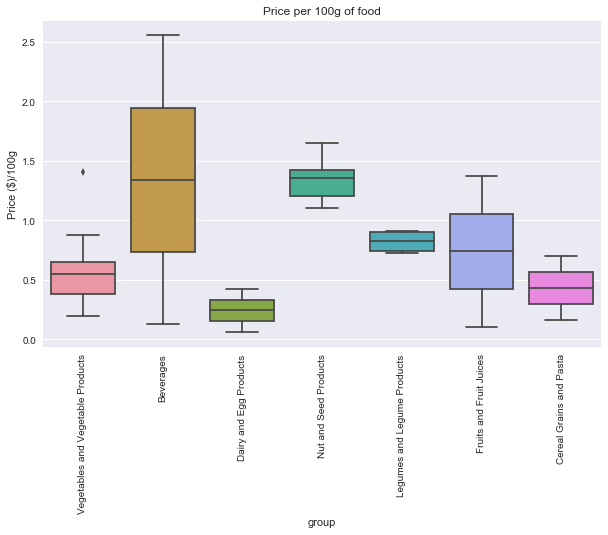

In [38]:
plt.figure(figsize=(10,6))
plt.title("Price per 100g of food")
plt.xticks(rotation=90)
sns.boxplot(data=df_nut, x='group', y='Price ($)/100g')

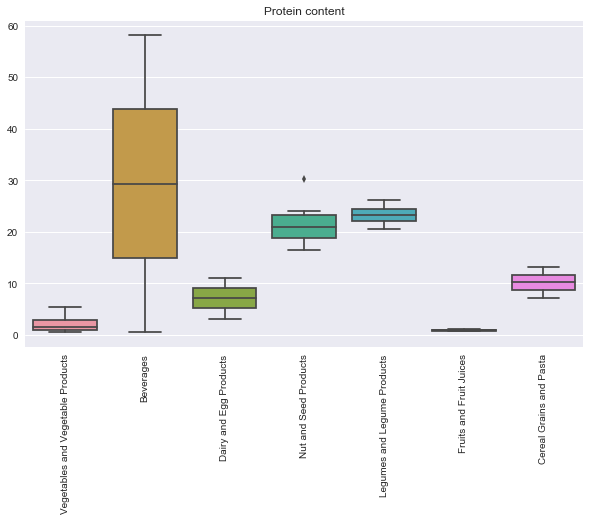

In [39]:
plt.figure(figsize=(10,6))
plt.title("Protein content")
plt.xticks(rotation=90)
sns.boxplot(x=list(df_nut['group']), y=list(df_nut['Protein (g)']))

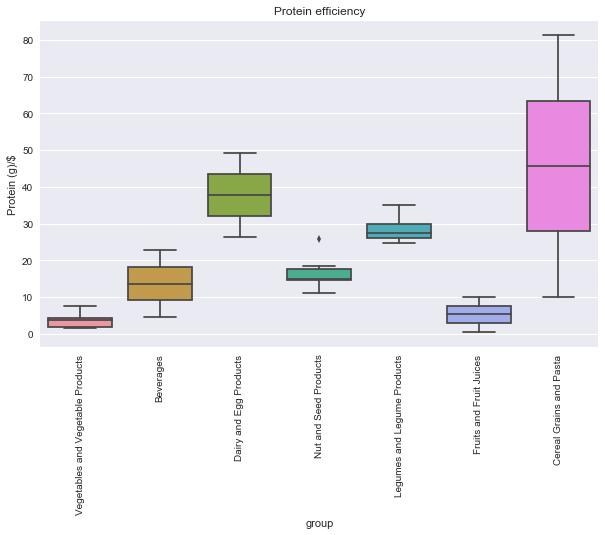

In [40]:
plt.figure(figsize=(10,6))
plt.title("Protein efficiency")
plt.xticks(rotation=90)
sns.boxplot(data=df_nut, x='group', y='Protein (g)/$')

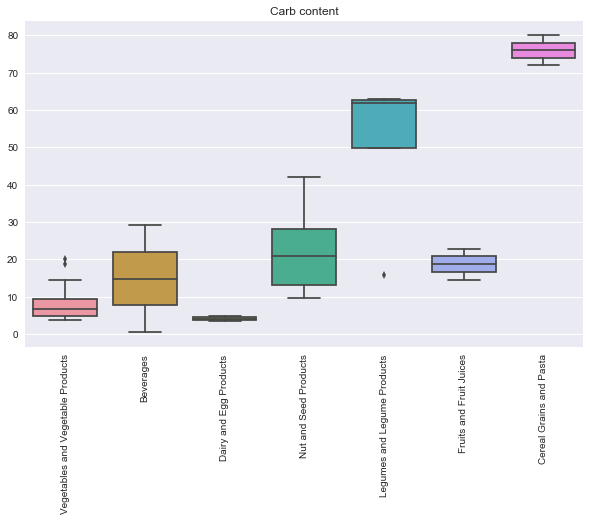

In [41]:
plt.figure(figsize=(10,6))
plt.title("Carb content")
plt.xticks(rotation=90)
sns.boxplot(x=list(df_nut['group']), y=list(df_nut['Carbohydrate, by difference (g)']))

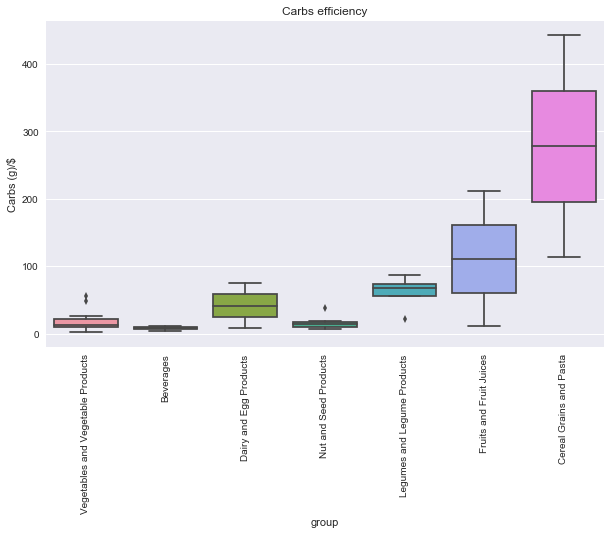

In [42]:
plt.figure(figsize=(10,6))
plt.title("Carbs efficiency")
plt.xticks(rotation=90)
sns.boxplot(data=df_nut, x='group', y='Carbs (g)/$')

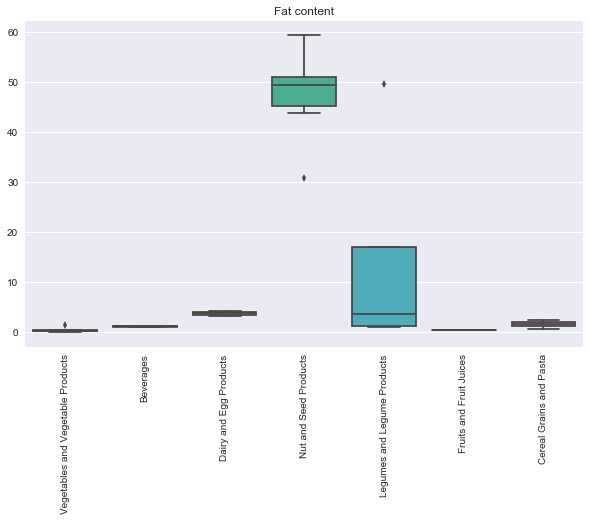

In [43]:
plt.figure(figsize=(10,6))
plt.title("Fat content")
plt.xticks(rotation=90)
sns.boxplot(x=list(df_nut['group']), y=list(df_nut['Total lipid (fat) (g)']))

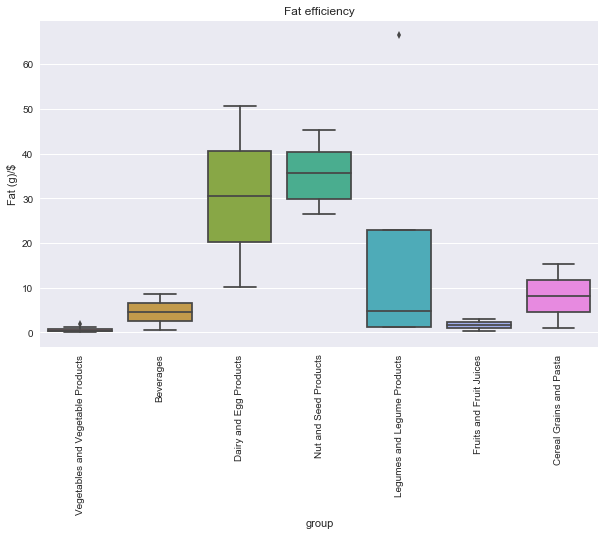

In [44]:
plt.figure(figsize=(10,6))
plt.title("Fat efficiency")
plt.xticks(rotation=90)
sns.boxplot(data=df_nut, x='group', y='Fat (g)/$')

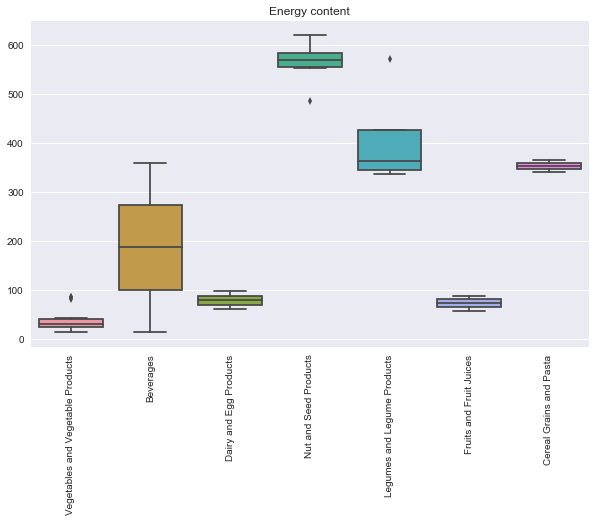

In [45]:
plt.figure(figsize=(10,6))
plt.title("Energy content")
plt.xticks(rotation=90)
sns.boxplot(x=list(df_nut['group']), y=list(df_nut['Energy (kcal)']))

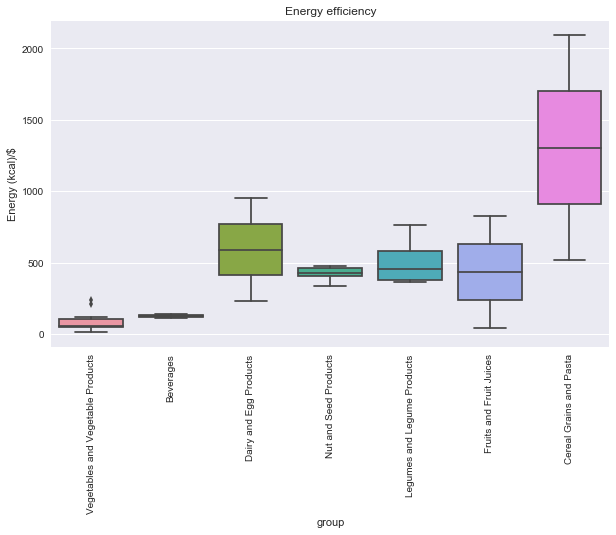

In [46]:
plt.figure(figsize=(10,6))
plt.title("Energy efficiency")
plt.xticks(rotation=90)
sns.boxplot(data=df_nut, x='group', y='Energy (kcal)/$')

**So here's what come out from the data above (to fix):**   
1. Price/100g wise, dairy is the cheapest, while nuts and seeds are more expensive (I'm ignoring beverages here since they are processed products - more on that later (no surprises, though I would have expected grains to be cheapest)
2. While legumes and nuts have the highest protein/g (not surprising since both of them are 'dry' with very little water content), on protein price efficiency (i.e. g protein/dollar), due to the cheap price, it seems wheat flour wins, which is pretty counterintuitive! Apart from that, it is dairy, and legumes next, which is not surprising
3. On carbs, no surprises. Grains are richest in carbs (this is an issue for me!) and cheap, so they have the highest price efficiency
4. For fat, as expected, nuts and seeds have the highest fat content, but due to the high price, they more or less tie with dairy for fat efficiency
5. On energy again, nuts and seeds have the highest energy per g, followed by legumes and grains. However, due to the cheap price of grains, they are highest on energy efficiency

**One interesting thing to do would be to look at the relationship between energy, protein, carbs and fat. Namely, is there a correlation between these. Let's use scikit-learn's linear regression to check this.**

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
lm = LinearRegression()

In [49]:
X = df_nut[['Protein (g)', 'Total lipid (fat) (g)', 'Carbohydrate, by difference (g)']]

In [50]:
y = df_nut['Energy (kcal)']

In [51]:
lm.fit(X,y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [52]:
lm.coef_

array([ 4.02607522,  8.22089958,  3.96215688])

In [53]:
lm.score(X,y)

0.99939715081065728

**Pretty clear that the values given for energy are derived from amount of protein, fat and carbs in the food in the following way:  
1g Protein -> 4.0 kcal,  
1g Fat -> 8.2 kcal,  
1g Carbs -> 4.0 kcal**

**Now let's move to our goal of finding the cheapest basket of foods to eat that takes care of our nutrition requirements.**  
For this, I will use the PuLP package for linear optimization

In [54]:
df_nut.fillna(value=0, inplace=True)
# required so there are no NaN's in the data and the optimization doesn't throw an error

In [55]:
from pulp import *

In [56]:
food = list(df_nut['name'])

In [57]:
price = df_nut[['name','Price ($)/100g']].set_index('name').to_dict()['Price ($)/100g']

**First let's consider only the macronutrients  
I have created a csv file with min and max for all the nutrients - micro and macro - (based on recommended daily allowances, and some modifications for what I want (e.g. higher protein)) and used that for adding the constraints through code efficiently**

In [58]:
nutrient=[]
for col in list(df_nut.columns[6:10]):  # for picking only the macronutrients
    nutrient.append(df_nut[['name', col]].set_index('name').to_dict())

In [60]:
nutrient_limits = pd.read_csv('nutrients.csv')

In [61]:
nutrient_limits.set_index('Nutrient', inplace=True)
nutrient_limits.head()

,Min,Max
Nutrient,,
Energy (kcal),1800.0,2200
Protein (g),160.0,180
Total lipid (fat) (g),90.0,100
"Carbohydrate, by difference (g)",200.0,300
"Fiber, total dietary (g)",30.0,100000


In [62]:
prob = LpProblem("Nutrition Cost", LpMinimize)  # Set up a linear programming problem

In [63]:
food_vars = LpVariable.dicts("Food",food,0)

In [64]:
prob += lpSum([price[i]*food_vars[i] for i in food])  # what to optimize

In [65]:
for item in nutrient:
    nutr = list(item.keys())[0]
    min = nutrient_limits.loc[nutr,'Min']
    max = nutrient_limits.loc[nutr,'Max']
    prob += lpSum([item[nutr][i] * food_vars[i] for i in food]) >= min
    prob += lpSum([item[nutr][i] * food_vars[i] for i in food]) <= max

In [66]:
prob.writeLP('foodmodel.lp')

In [67]:
prob.solve()

1

In [68]:
print("Status:", LpStatus[prob.status])

Status: Optimal


In [69]:
for v in prob.variables():
    if v.varValue != None:
        if v.varValue > 0:
            print(v.name, "=", v.varValue)

Food_Cheese,_cottage,_creamed,_large_or_small_curd = 9.1768918
Food_Milk,_whole,_3.25%_milkfat,_with_added_vitamin_D = 7.1401236
Food_Peanuts,_spanish,_raw = 0.46186638
Food_Wheat_flour,_whole_grain = 1.7701566


**This is interesting. So the optimization is telling me that I should eat lots of dairy (cheese (918 g) and milk (714 g)), quite some wheat (177 g), and some peanuts (46 g) to cheaply get all my macronutrients in the cheapest way!**  

**However that doesn't sound like a very balanced diet to me, so let's add some more constraints around the micronutrients and other things**

In [70]:
micro_nutrient=[]
for col in list(df_nut.columns[10:38]):
    micro_nutrient.append(df_nut[['name', col]].set_index('name').to_dict())

In [71]:
for item in micro_nutrient:
    nutr = list(item.keys())[0]
    min = nutrient_limits.loc[nutr,'Min']
    max = nutrient_limits.loc[nutr,'Max']
    prob += lpSum([item[nutr][i] * food_vars[i] for i in food]) >= min
    prob += lpSum([item[nutr][i] * food_vars[i] for i in food]) <= max

In [72]:
prob.writeLP('foodmodel.lp')

In [73]:
prob.solve()

1

In [74]:
print("Status:", LpStatus[prob.status])

Status: Optimal


In [75]:
for v in prob.variables():
    if v.varValue != None:
        if v.varValue > 0:
            print(v.name, "=", v.varValue)

Food_Beverages,_Whey_protein_powder_isolate = 1.2099521
Food_Broccoli,_raw = 0.51298586
Food_Milk,_whole,_3.25%_milkfat,_with_added_vitamin_D = 11.538462
Food_Mung_beans,_mature_seeds,_raw = 0.7681362
Food_Peanuts,_spanish,_raw = 0.87414417
Food_Seeds,_sunflower_seed_kernels,_dried = 0.097747467
Food_Wheat_flour,_whole_grain = 0.65426345


**Ok, this seems to be a much more balanced diet, though I'm still surprised at the small amount of veggies that is suggested (only 51 g of broccoli). Given thw high levels of protein I've chosen (160-180g) while restricting calories, the mix shifts significantly towards whey protein (121 g or 4 scoops, I usually have 1 scoop a day) and milk (suggests drinking over 1 litre of milk/day), but also has a mix of several other foods: broccoli, mung beans (77 g), and a mix of nuts and seeds: peanuts (87 g), and a little bit of sunflower seeds. There is still some amount of wheat intake (65 g, which is about 2-3 slices of bread as per my estimate) suggested based on the restrictions.**

In [76]:
print("Total Cost = ", value(prob.objective))

Total Cost =  5.623633464147014


**The cost of a more balanced diet is 5.6 dollars per day. So not so bad!**